# Taller 1

## 0. Preparación inicial

### 0.1. Importación de librerías y configuraciones

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [226]:
# Pandas configuration for extending the number of columns and rows to show
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### 0.2. Carga de datos

In [227]:
# Loading the CSV file as dataframe
hotels_df = pd.read_csv("./data/hotel_bookings_modified.csv")
hotels_df_dict = pd.read_excel("./data/Hotel Bookings Demand Data Dictionary.xlsx")

## 1. Entendimiento de los datos

Como primer paso es necesario revisar el tipo de variable de cada característica, así como el número de reservas con los que se cuenta.

In [228]:
# Showing dataframe dimensions
hotels_df.shape

(58895, 33)

| #  | Columna                       | Tipo      | Descripción | Clasificación |
|----|-------------------------------|-----------|-------------|---------------|
| 1  | hotel                         | text      | Hotel (H1 = Resort Hotel o H2 = City Hotel) | Cualitativa nominal |
| 2  | is_canceled                   | boolean   | Indica si la reserva fue cancelada (1) o no (0) | Cualitativa nominal |
| 3  | lead_time                     | integer   | Días entre la fecha en que se realizó la reserva en el PMS y la fecha de llegada | Cuantitativa discreta |
| 4  | arrival_date_year             | integer   | Año de la fecha de llegada | Cuantitativa discreta |
| 5  | arrival_date_month            | text      | Mes de la fecha de llegada | Cualitativa ordinal |
| 6  | arrival_date_week_number      | integer   | Número de semana del año de la fecha de llegada | Cuantitativa discreta |
| 7  | arrival_date_day_of_month     | integer   | Día del mes de la fecha de llegada | Cuantitativa discreta |
| 8  | stays_in_weekend_nights       | integer   | Noches de fin de semana (sábado o domingo) reservadas o utilizadas | Cuantitativa discreta |
| 9  | stays_in_week_nights          | integer   | Noches de semana (lunes a viernes) reservadas o utilizadas | Cuantitativa discreta |
| 10 | adults                        | integer   | Número de adultos | Cuantitativa discreta |
| 11 | children                      | integer   | Número de niños | Cuantitativa discreta |
| 12 | babies                        | integer   | Número de bebés | Cuantitativa discreta |
| 13 | meal                          | text      | Tipo de plan de comidas reservado | Cualitativa nominal |
| 14 | country                       | text      | País de origen en formato ISO 3155–3:2013 | Cualitativa nominal |
| 15 | market_segment                | text      | Segmento de mercado (TA = Travel Agents, TO = Tour Operators) | Cualitativa nominal |
| 16 | distribution_channel          | text      | Canal de distribución (TA = Travel Agents, TO = Tour Operators) | Cualitativa nominal |
| 17 | is_repeated_guest             | boolean   | Indica si es un cliente repetido (1) o no (0) | Cualitativa nominal |
| 18 | previous_cancellations        | integer   | Número de reservas previas canceladas por el cliente | Cuantitativa discreta |
| 19 | previous_bookings_not_canceled| integer   | Número de reservas previas no canceladas por el cliente | Cuantitativa discreta |
| 20 | reserved_room_type            | text      | Código del tipo de habitación reservada | Cualitativa nominal |
| 21 | assigned_room_type            | text      | Código del tipo de habitación asignada (puede diferir de la reservada) | Cualitativa nominal |
| 22 | booking_changes               | integer   | Número de cambios realizados a la reserva | Cuantitativa discreta |
| 23 | deposit_type                  | text      | Tipo de depósito | Cualitativa nominal |
| 24 | agent                         | integer   | ID de la agencia de viajes que hizo la reserva | Cualitativa ordinal |
| 25 | company                       | integer   | ID de la compañía/entidad responsable de la reserva | Cualitativa ordinal |
| 26 | days_in_waiting_list          | integer   | Días en lista de espera antes de la confirmación | Cuantitativa discreta |
| 27 | customer_type                 | text      | Tipo de cliente | Cualitativa nominal |
| 28 | adr                           | numeric   | Tarifa diaria promedio (ADR) | Cuantitativa continua |
| 29 | required_car_parking_spaces   | integer   | Número de espacios de parqueadero requeridos | Cuantitativa discreta |
| 30 | total_of_special_requests     | integer   | Número de solicitudes especiales del cliente | Cuantitativa discreta |
| 31 | reservation_status            | text      | Estado final de la reserva | Cualitativa nominal |
| 32 | reservation_status_date       | date      | Fecha en la que se estableció el último estado de la reserva | Cualitativa ordinal |


Gracias al diccionario, es posible identificar y señalar las variables cuantitativas y cualitativas del dataset.

### Atributos importantes

De acuerdo al contexto y a las necesidades del negocio en cuanto a optimizar la estrategia de ocupación de los hoteles se seleccionaron las siguientes 5 tipos de variables. La razón por la que no se seleccionaron únicamente 2 variables es debido a que no existe una sola columna con número de personas en la reserva, con lo cual lo más cercano es evaluar tanto el número de adultos, como el número de niños y bebés dentro de una reserva:

1. Fecha de llegada (arrival_date)

Justificación: Captura la estacionalidad (meses/temporadas, feriados, puentes, fines de semana) y patrones de demanda temporales. La ocupación podría variar fuertemente por día/mes/año.

2. Lead time (lead_time)

Justificación:  Indica el horizonte de reserva (cuánto antes reserva el cliente). Es clave para política de precio, inventarios y gestionar cancelaciones: reservas con lead time largo suelen comportarse distinto (más propensas a cambios/cancelaciones o más price-sensitive).

3. ADR (adr) — tarifa diaria promedio

Justificación: es la variable de precio/valor monetario y tiene efecto directo sobre la demanda y los ingresos.

4. Duración de la estancia (stays_in_week_nights + stays_in_weekend_nights → length_of_stay)

Justificación: la ocupación (camas/room nights) se construye por la duración de cada reserva. Entender patrones de length-of-stay ayuda a planificación de inventario y promociones (ej. paquetes para estancias largas).


5. Composición del grupo  (adults + children + babies)

Justificación: Entender la población es vital debido a que afecta el tipo de habitación que se escoge,la oferta de servicios y la demanda (familias vs business).

### Análisis univariado

A continuación se muestra el comportamiento de las variables definidas anteriormente:

In [229]:
# Función para imprimir resumen
def resumen_variable(df, col, nombre):
    valores = df[col].dropna()
    print(f"\n{nombre}")
    print(f"- Media: {valores.mean():.2f}")
    print(f"- Mediana: {valores.median():.2f}")
    print(f"- Desviación estándar: {valores.std():.2f}")
    print(f"- Percentil 25: {np.percentile(valores, 25):.2f}")
    print(f"- Percentil 75: {np.percentile(valores, 75):.2f}")
    print(f"- Mínimo: {valores.min():.2f}")
    print(f"- Máximo: {valores.max():.2f}")
    if col == "group_size":
        moda = valores.mode().iloc[0]
        print(f"- Moda: {moda}")

#### Fecha de llegada

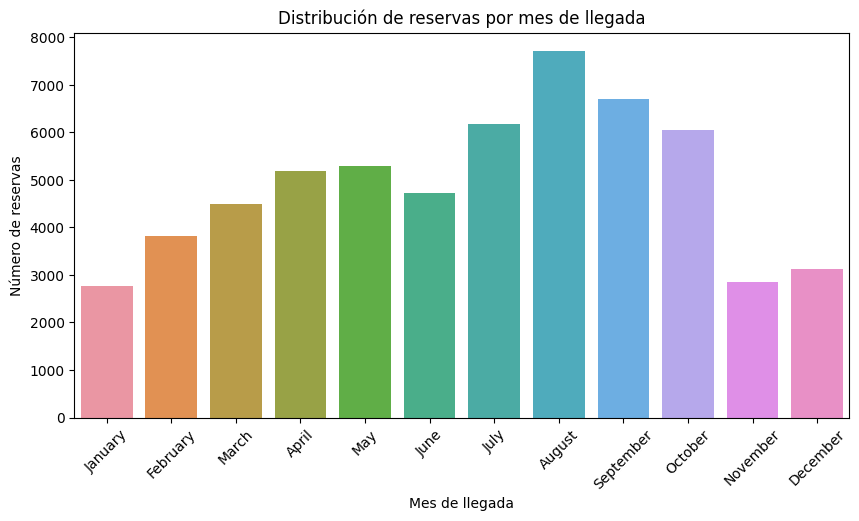

In [230]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(
    data=hotels_df, 
    x="arrival_date_month", 
    order=[
        "January","February","March","April","May","June",
        "July","August","September","October","November","December"
    ]
)
plt.title("Distribución de reservas por mes de llegada")
plt.xlabel("Mes de llegada")
plt.ylabel("Número de reservas")
plt.xticks(rotation=45)
plt.show()


#### Lead time

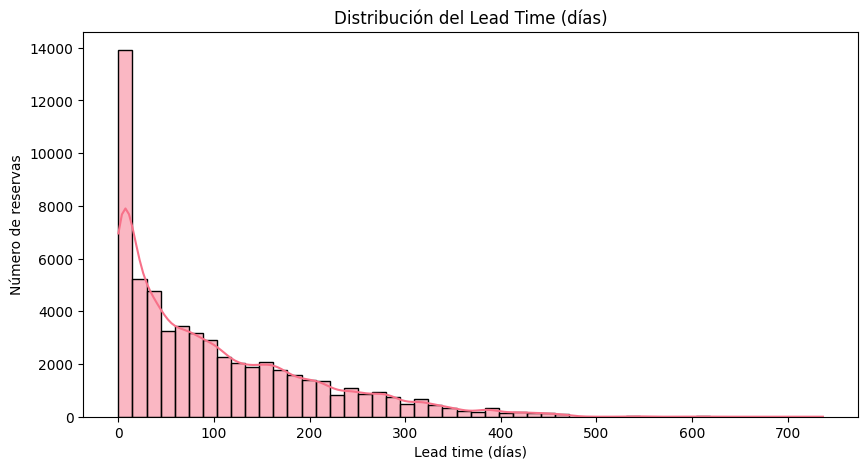


Lead time (días)
- Media: 100.05
- Mediana: 69.00
- Desviación estándar: 101.16
- Percentil 25: 17.00
- Percentil 75: 157.00
- Mínimo: 0.00
- Máximo: 737.00


In [231]:
plt.figure(figsize=(10,5))
sns.histplot(hotels_df["lead_time"], bins=50, kde=True)
plt.title("Distribución del Lead Time (días)")
plt.xlabel("Lead time (días)")
plt.ylabel("Número de reservas")
plt.show()

resumen_variable(hotels_df, "lead_time", "Lead time (días)")



#### ADR

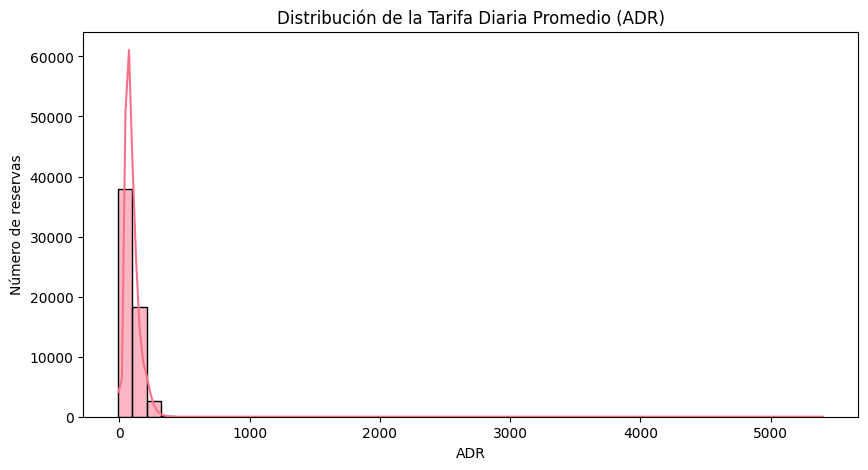


ADR (Average Daily Rate)
- Media: 96.25
- Mediana: 84.00
- Desviación estándar: 58.56
- Percentil 25: 60.00
- Percentil 75: 120.00
- Mínimo: -6.38
- Máximo: 5400.00


In [232]:
plt.figure(figsize=(10,5))
sns.histplot(hotels_df["adr"], bins=50, kde=True)
plt.title("Distribución de la Tarifa Diaria Promedio (ADR)")
plt.xlabel("ADR")
plt.ylabel("Número de reservas")
plt.show()


resumen_variable(hotels_df, "adr", "ADR (Average Daily Rate)")



#### Duración de la estancia (length_of_stay)

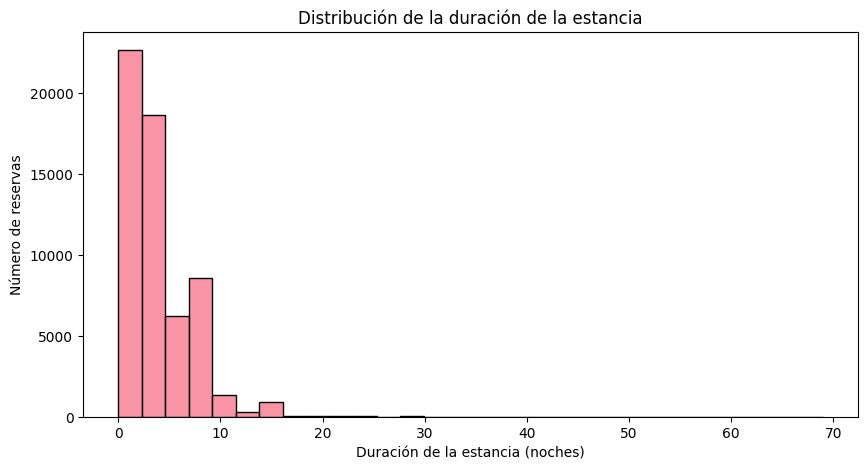


Duración de la estancia (noches)
- Media: 3.91
- Mediana: 3.00
- Desviación estándar: 3.05
- Percentil 25: 2.00
- Percentil 75: 5.00
- Mínimo: 0.00
- Máximo: 69.00


In [233]:
# Crear columna length_of_stay
hotels_df["length_of_stay"] = hotels_df["stays_in_week_nights"] + hotels_df["stays_in_weekend_nights"]

plt.figure(figsize=(10,5))
sns.histplot(hotels_df["length_of_stay"], bins=30, kde=False)
plt.title("Distribución de la duración de la estancia")
plt.xlabel("Duración de la estancia (noches)")
plt.ylabel("Número de reservas")
plt.show()

resumen_variable(hotels_df, "length_of_stay", "Duración de la estancia (noches)")




#### Composición del grupo (adults + children + babies)

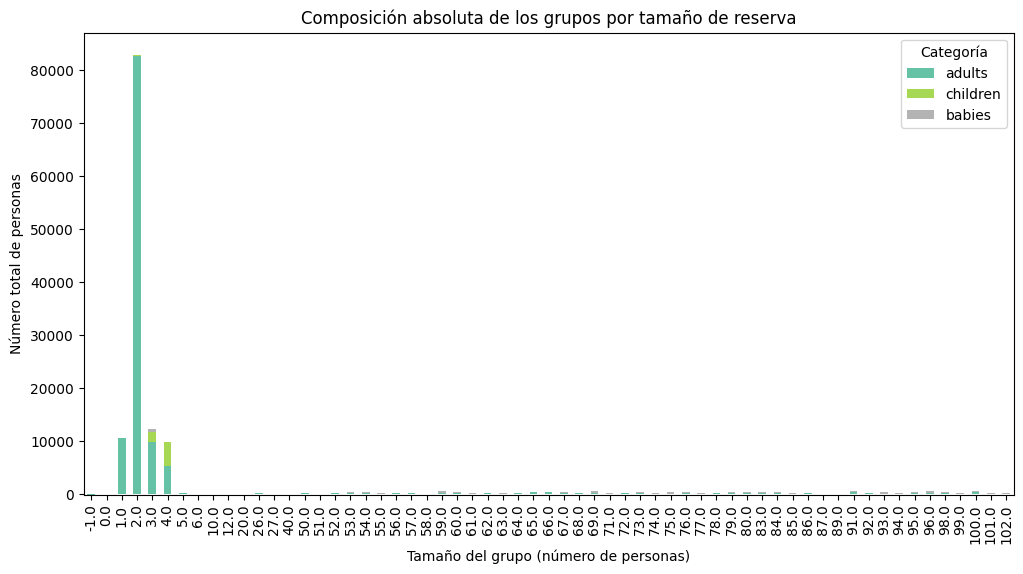


Composición de grupo (personas por reserva)
- Media: 2.22
- Mediana: 2.00
- Desviación estándar: 4.31
- Percentil 25: 2.00
- Percentil 75: 2.00
- Mínimo: -1.00
- Máximo: 102.00
- Moda: 2.0


In [234]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que no haya nulos
hotels_df["children"] = hotels_df["children"].fillna(0)

# Calcular tamaño de grupo
hotels_df["group_size"] = hotels_df["adults"] + hotels_df["children"] + hotels_df["babies"]

# Sumar adultos, niños y bebés por cada tamaño de grupo
composition = hotels_df.groupby("group_size")[["adults", "children", "babies"]].sum()

# Gráfico de barras apiladas en valores absolutos
composition.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12,6), 
    colormap="Set2"
)

plt.title("Composición absoluta de los grupos por tamaño de reserva")
plt.xlabel("Tamaño del grupo (número de personas)")
plt.ylabel("Número total de personas")
plt.legend(title="Categoría")
plt.show()

resumen_variable(hotels_df, "group_size", "Composición de grupo (personas por reserva)")




### Información general del dataset

In [235]:
# Showing column types
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58895 entries, 0 to 58894
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           58895 non-null  object 
 1   is_canceled                     58895 non-null  int64  
 2   lead_time                       58895 non-null  int64  
 3   arrival_date_year               58307 non-null  float64
 4   arrival_date_month              58895 non-null  object 
 5   arrival_date_week_number        58895 non-null  int64  
 6   arrival_date_day_of_month       58895 non-null  int64  
 7   stays_in_weekend_nights         58895 non-null  int64  
 8   stays_in_week_nights            58895 non-null  int64  
 9   adults                          58895 non-null  int64  
 10  children                        58895 non-null  float64
 11  babies                          58895 non-null  int64  
 12  meal                            

Gracias a esta pequeña comparación ya fue posible identificar columnas que no existen en el diccionario de los datos, por ejemplo la columna `kids` no aparece en el diccionario. Sin embargo, sí existen otras dos columnas con el mismo propósito las cuales son `children` `babies`. Esto se tendrá en cuenta más adelante.

In [236]:
hotels_df.sample(5) # Showing a sample of n rows

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,kids,length_of_stay,group_size
33268,Resort Hotel,0,1,2017.0,February,7,16,0,3,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,6.0,NaN,0.0,Transient,57.00,1.0,0.0,Check-Out,2017-02-19,NaN,3,2.0
52921,City Hotel,1,71,2016.0,June,25,14,0,3,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,236.0,NaN,0.0,Transient,120.00,0.0,0.0,Canceled,2016-04-27,NaN,3,1.0
56783,City Hotel,1,48,2016.0,September,38,14,0,2,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,281.0,NaN,0.0,Transient-Party,130.00,0.0,0.0,Canceled,2016-09-06,NaN,2,2.0
13132,Resort Hotel,1,27,2017.0,August,31,1,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0.0,Transient,215.71,0.0,1.0,Canceled,2017-07-15,NaN,7,2.0
48177,City Hotel,1,91,2016.0,March,12,18,0,2,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29.0,NaN,20.0,Transient,75.00,0.0,0.0,Canceled,2016-02-03,NaN,2,1.0


### Detección de valores atípicos

In [237]:
hotels_df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,kids,length_of_stay,group_size
count,58895.000000,58895.000000,58307.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,58895.000000,49763.000000,58894.000000,58894.000000,58306.000000,58894.000000,201.000000,58895.000000,58895.000000
mean,0.411393,100.050904,2205.522939,27.837389,15.766432,1.058154,2.847576,1.969148,0.112930,0.136599,0.030189,0.069191,0.099618,0.243009,146.983080,3.525979,96.250426,0.096697,0.512225,34.417910,3.905731,2.218677
std,0.492090,101.162420,1837.392466,13.346053,8.783036,1.093032,2.235486,2.943454,0.419697,3.115889,0.171109,1.102138,0.829166,0.695205,120.114987,21.841676,58.555599,0.300382,0.768378,38.571032,3.053648,4.305396
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.380000,0.000000,0.000000,-1.000000,0.000000,-1.000000
25%,0.000000,17.000000,2016.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,60.000000,0.000000,0.000000,-1.000000,2.000000,2.000000
50%,0.000000,69.000000,2016.000000,29.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,196.000000,0.000000,84.000000,0.000000,0.000000,-1.000000,3.000000,2.000000
75%,1.000000,157.000000,2016.000000,38.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,0.000000,120.000000,0.000000,1.000000,65.000000,5.000000,2.000000
max,1.000000,737.000000,20016.000000,53.000000,31.000000,19.000000,50.000000,100.000000,10.000000,100.000000,1.000000,26.000000,30.000000,20.000000,535.000000,391.000000,5400.000000,8.000000,5.000000,100.000000,69.000000,102.000000


| Columna                      | Problema principal                                                                 | Evidencia (describe / info)                                 |
|------------------------------|-----------------------------------------------------------------------------------|-------------------------------------------------------------|
| arrival_date_year            | Valores fuera de rango (typos: ej. `20016`) que distorsionan análisis temporales  | `min=2015`, `25%=2016`, `max=20016`, `mean≈2205`            |
| adults                       | Valores negativos (-1) en un conteo que no puede ser negativo                     | `min = -1`                                                  |
| children                     | Valores negativos (-1) y tipo float por algunos nulos                              | `min = -1`, `count=58891`                                   |
| adr                          | Tarifas negativas (no tiene sentido económico)                                    | `min = -6.38`                                               | 
| stays_in_week_nights         | Valores máximos muy altos (posibles outliers o errores de entrada)                | `max = 50`                                                  |
| stays_in_weekend_nights      | Valores máximos inusuales (posible outlier)                                       | `max = 19`                                                  |
| agent                        | Muchos nulos (posible ausencia de agencia)                                        | `count=49763`                                               |


Gracias a la tabla de descripción de los datos es posible identificar las diferentes inconsistencias que existen dentro del conjunto de datos.

### Registros duplicados

In [238]:
print("Total de registros duplicados iniciales: ",hotels_df.duplicated(keep = False).sum())
print("Porcentaje de registros duplicados ",round((hotels_df.duplicated(keep = False).sum()/hotels_df.shape[0])*100,2), "%")

Total de registros duplicados iniciales:  17159
Porcentaje de registros duplicados  29.13 %


Hay una cantidad considerable de registros duplicados, esto es importante tenerlo en cuenta porque significa que no hay tantos registros útiles como se pensaba inicialmente.

In [239]:
hotels_df.shape

(58895, 35)

### Registros nulos

In [240]:
round(100*(hotels_df.isnull().sum()/len(hotels_df)), 2).sort_values(ascending=False)

kids                              99.66
company                           94.09
agent                             15.51
arrival_date_year                  1.00
reservation_status                 1.00
required_car_parking_spaces        1.00
customer_type                      1.00
country                            0.81
hotel                              0.00
booking_changes                    0.00
deposit_type                       0.00
adr                                0.00
days_in_waiting_list               0.00
reserved_room_type                 0.00
total_of_special_requests          0.00
reservation_status_date            0.00
length_of_stay                     0.00
assigned_room_type                 0.00
previous_cancellations             0.00
previous_bookings_not_canceled     0.00
is_canceled                        0.00
is_repeated_guest                  0.00
distribution_channel               0.00
market_segment                     0.00
meal                               0.00


Como podemos ver en la celda anterior, de todas las columnas (atributos) dentro del dataset, hay dos en particular que están compuestas mayormente por datos vacíos o nulos: "Company" (94.09% de datos nulos) y "Kids" (99.66% de datos nulos). Además, el atributo "Agent" cuenta con un 15.51% de datos nulos. 


### Decisiones de tranformación de los datos

Después de haber realizado la exploración general de los datos y haber seleccionado y analizado las variables más importantes se tomaron las siguientes decisiones evaluadas en ciertos pilares de la calidad de datos.

#### Consistencia
**Decisión 1:** 

Eliminar columnas que contengan valores nulos en casi la totalidad de los registros, en este caso "Kids". Para "Company" lo que se hará es imputar los datos, pues si bien no hubo empresa que reservara, tiene sentido poner en esta casilla para los valores nulos una etiqueta del estilo 0 para poder simular con ese ID cuando no hay compañía.

Dada la naturaleza del atributo, en el que cada número representa el ID de la agencia de viajes que hizo la reserva, podemos interpretar el dato nulo como una reserva que se hizo sin ayuda de agencia de viajes alguna. De ahí, realizaremos imputación de datos, cambiando el NaN por el ID 0. Elegimos este porque, como visto en celdas anteriores, el mínimo ID es de 1 y el máximo es de 535, con lo cual este ID pasará a ser considerado como aquellas reservas que no fueron hechas con ayuda de una agencia de viajes.

Finalmente, respecto a los demás atributos, la gran mayoría tiene cero datos nulos... con algunos pocos con 1% o menos de datos nulos. Para estos, se eliminaron las filas que los contienen.


#### Validez
**Decisión 2:** Eliminar los registros que tengan valores negativos o valores por fuera de los rangos establecidos, con el objetivo de respetar lar reglas impuestas a cada característica. Se eliminan sobre todo aquellos valores atípicos que se encontraron en el número de adultos y niños, así como duraciones y valores considerados outliers.
#### Unicidad
**Decisión 3:** Eliminar los duplicados para asegurar la aparición de cada reserva solo una vez. En este caso, cerca del 29.13% del dataset tiene valores duplicados. Esto es grave pues el análisis daría resultados que son erróneos al contar dos veces la misma reserva. Dado el contexto del negocio y que es altamente improbable que una reserva coincida exáctamente en todo con otra reserva se considera que estos registros duplicados son en efecto un error en los datos.
#### Completitud
Al cumplir con todas las decisiones mencionadas anteriormente se puede asegurar que el 100% de los datos están completos.

> **Atención**  
> No se eliminan los valores extremadamente altos porque, aunque parezcan atípicos, pueden ser casos reales.  
> En este contexto, es posible que existan reservas con un número muy grande de personas o tarifas muy elevadas, por lo que dichos valores se mantienen para no perder información válida del negocio.


In [241]:
hotels_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'kids',
       'length_of_stay', 'group_size'],
      dtype='object')

## 2. Preparación de los datos

In [242]:
def consistencia(df: pd.DataFrame) -> pd.DataFrame:
    """
    - Elimina columnas con casi todos los valores nulos (ej. 'Kids').
    - Imputa valores nulos en 'Company' con 'Personal'.
    - Imputa valores nulos en 'Agent' con 0 (reserva sin agencia).
    - Elimina filas con valores nulos en cualquier otra columna.
    """
    # Eliminar columna Kids
    if "kids" in df.columns:
        df = df.drop(columns=["kids"])
    
    # Imputar Company con "Personal" como PR imitando el ID de una reserva con NU
    if "company" in df.columns:
        df["company"] = pd.to_numeric(df["company"], errors="coerce").fillna(0).astype(int)


    
    # Imputar Agent con 0
    if "agent" in df.columns:
        df["agent"] = df["agent"].fillna(0)
    
    return df


def validez(df: pd.DataFrame) -> pd.DataFrame:
    """
    Elimina registros con valores negativos o fuera de los rangos establecidos:
    - Adultos, niños, bebés >= 0
    - ADR >= 0
    - Duración de estancia >= 0
    """
    conditions = (
        (df["adults"] >= 0) &
        (df["children"] >= 0) &
        (df["babies"] >= 0) &
        (df["adr"] >= 0) &
        (df["stays_in_weekend_nights"] >= 0) &
        (df["stays_in_week_nights"] >= 0)
    )
    df = df[conditions].copy()

    if 'arrival_date_year' in df.columns:
        df_valid = df[df['arrival_date_year'] <= 2050]
    
    return df_valid


def unicidad(df: pd.DataFrame) -> pd.DataFrame:
    """
    Elimina registros duplicados en su totalidad.
    """
    df = df.drop_duplicates()
    return df


def procesar_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Función final para asegurar completitud tras aplicar consistencia, validez y unicidad.
    """
    df = consistencia(df)
    print(df.shape)
    df = validez(df)
    print(df.shape)
    df = unicidad(df)
    print(df.shape)
    return df


In [243]:
hotels_df_clean = procesar_dataset(hotels_df)

(58895, 34)
(57506, 34)
(44131, 34)


In [244]:
hotels_df_clean.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,length_of_stay,group_size
count,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,44131.000000,43567.000000,44131.000000,44131.000000,44131.000000
mean,0.335116,83.314563,2016.032653,27.370261,15.761302,1.137069,2.990166,2.021549,0.144207,0.182729,0.037819,0.020960,0.128549,0.289638,137.490132,13.611634,1.175092,99.812646,0.125278,0.620720,4.127235,2.348485
std,0.472036,89.238819,0.699486,13.445594,8.844349,1.126407,2.367130,3.345585,0.469806,3.588165,0.190761,0.432521,0.942437,0.763159,122.255765,62.193201,12.737098,58.456503,0.336744,0.806382,3.241201,4.922397
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,11.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,58.000000,0.000000,0.000000,2.000000,2.000000
50%,0.000000,51.000000,2016.000000,29.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,175.000000,0.000000,0.000000,86.000000,0.000000,0.000000,3.000000,2.000000
75%,1.000000,132.000000,2017.000000,37.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,0.000000,0.000000,130.000000,0.000000,1.000000,6.000000,2.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,100.000000,10.000000,100.000000,1.000000,26.000000,30.000000,20.000000,535.000000,543.000000,391.000000,508.000000,8.000000,5.000000,69.000000,102.000000


In [245]:
hotels_df_clean.company

0         0
1         0
2         0
3         0
4         0
         ..
58877     0
58878     0
58879     0
58881     0
58882    51
Name: company, Length: 44131, dtype: int32

Despues de comprobar la nueva distribución de los datos se da por terminada la preparación de los datos asegurando los cuatros aspectos mencionados de la calidad de datos.

## 3. Planteamiento de la estrategia

### Justificación y Enfoque

Basándose en las **5 variables clave** identificadas en el análisis univariado (fecha de llegada, lead time, ADR, duración de estancia y composición del grupo), se propone una estrategia de análisis en **4 fases complementarias** que permitirá descubrir patrones complejos y generar recomendaciones accionables para reducir cancelaciones y optimizar ocupación hotelera.

La estrategia se fundamenta en que estas variables no actúan de forma aislada, sino que interactúan entre sí creando perfiles de comportamiento específicos. Por ejemplo, un cliente que reserva con mucha anticipación (alto lead time) podría tener diferente propensión a cancelar dependiendo de si viaja en temporada alta o baja, o si su grupo es familiar versus individual. 

### Fases de la Estrategia

**Fase 1: Análisis de Patrones de Cancelación** - Se utilizarán las variables identificadas para determinar cuáles tienen mayor poder predictivo sobre las cancelaciones. Esto incluye explorar cómo el lead time, la estacionalidad (fecha de llegada), el precio (ADR), la duración planificada y el tamaño del grupo se correlacionan con la decisión de cancelar.

**Fase 2: Segmentación de Clientes mediante Clustering** - Se aplicarán técnicas de reducción de dimensionalidad (PCA) seguidas de clustering para identificar segmentos naturales de huéspedes basados en estas 5 variables. Cada segmento revelará patrones de comportamiento únicos que permitirán estrategias diferenciadas.

**Fase 3: Análisis Temporal y Estacionalidad** - Se examinará cómo la interacción entre estacionalidad, lead time y tipo de hotel afecta tanto las cancelaciones como los patrones de pricing y ocupación, revelando oportunidades de optimización por períodos específicos.

**Fase 4: Análisis de Canales de Distribución y Empresas** - Se evaluará el potencial y rendimiento de las diferentes agencias de viaje y empresas corporativas, identificando cuáles son los mejores socios comerciales en términos de volumen, rentabilidad, tasas de cancelación y valor promedio por transacción. Esto permitirá optimizar las estrategias de partnership y enfocar esfuerzos comerciales en los canales más rentables.

Esta aproximación multivariada permitirá ir más allá de insights univariados y descubrir relaciones complejas que generen recomendaciones estratégicas precisas y basadas en evidencia, abarcando tanto la perspectiva del cliente final como la de los socios comerciales.

### Implementación

In [246]:

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

def analizar_patrones_cancelacion(df):
    """
    Analiza qué factores están más asociados con las cancelaciones
    Identifica variables predictivas y patrones de comportamiento
    """
    print("="*60)
    print("ANÁLISIS DE PATRONES DE CANCELACIÓN")
    print("="*60)
    
    
    # Correlación con variables numéricas
    print("\nCORRELACIONES CON CANCELACIONES")
    variables_numericas = ['lead_time', 'adr', 'length_of_stay', 'group_size', 
                          'booking_changes', 'days_in_waiting_list', 'total_of_special_requests']
    
    correlaciones = []
    for var in variables_numericas:
        if var in df.columns:
            corr = df[var].corr(df['is_canceled'])
            correlaciones.append({'Variable': var, 'Correlación': corr})
    
    corr_df = pd.DataFrame(correlaciones).sort_values('Correlación', key=abs, ascending=False)
    print(corr_df.round(4))
    
    # Visualización de correlaciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Distribución de Variables Clave por Estado de Cancelación', fontsize=16)
    
    # Lead time
    sns.boxplot(data=df, x='is_canceled', y='lead_time', ax=axes[0,0])
    axes[0,0].set_title('Lead Time vs Cancelación')
    axes[0,0].set_xlabel('Cancelado (0=No, 1=Sí)')
    
    # ADR
    sns.boxplot(data=df, x='is_canceled', y='adr', ax=axes[0,1])
    axes[0,1].set_title('ADR vs Cancelación')
    axes[0,1].set_xlabel('Cancelado (0=No, 1=Sí)')
    
    # Length of stay
    sns.boxplot(data=df, x='is_canceled', y='length_of_stay', ax=axes[1,0])
    axes[1,0].set_title('Duración de Estancia vs Cancelación')
    axes[1,0].set_xlabel('Cancelado (0=No, 1=Sí)')
    
    # Group size
    sns.boxplot(data=df, x='is_canceled', y='group_size', ax=axes[1,1])
    axes[1,1].set_title('Tamaño de Grupo vs Cancelación')
    axes[1,1].set_xlabel('Cancelado (0=No, 1=Sí)')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis por tipo de hotel
    print("\nCANCELACIONES POR TIPO DE HOTEL")
    hotel_cancelaciones = df.groupby('hotel')['is_canceled'].agg(['count', 'sum', 'mean']).round(4)
    hotel_cancelaciones.columns = ['Total_Reservas', 'Cancelaciones', 'Tasa_Cancelacion']
    print(hotel_cancelaciones)
    
    # Análisis por mes
    print("\nCANCELACIONES POR MES")
    orden_meses = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    mes_cancelaciones = df.groupby('arrival_date_month')['is_canceled'].mean().reindex(orden_meses)
    print(mes_cancelaciones.round(4))
    
    # Visualización temporal
    plt.figure(figsize=(12, 5))
    mes_cancelaciones.plot(kind='bar', color='coral')
    plt.title('Tasa de Cancelación por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Tasa de Cancelación')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return corr_df, hotel_cancelaciones, mes_cancelaciones


In [247]:


def analizar_estacionalidad_temporal(df):
    """
    Análisis temporal y estacionalidad
    Examina patrones temporales, estacionalidad y diferencias entre tipos de hotel
    """
    print("\n" + "="*60)
    print("ANÁLISIS TEMPORAL Y ESTACIONALIDAD")
    print("="*60)
    
    # Análisis de estacionalidad
    print("\nANÁLISIS DE ESTACIONALIDAD")
    
    orden_meses = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Reservas por mes y tipo de hotel
    estacionalidad = df.groupby(['arrival_date_month', 'hotel']).agg({
        'is_canceled': ['count', 'mean'],
        'adr': 'mean',
        'length_of_stay': 'mean' if 'length_of_stay' in df.columns else lambda x: (df.loc[x.index, 'stays_in_week_nights'] + df.loc[x.index, 'stays_in_weekend_nights']).mean()
    }).round(2)
    
    # Crear length_of_stay si no existe
    if 'length_of_stay' not in df.columns:
        df['length_of_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
    
    # Gráfico de estacionalidad
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análisis de Estacionalidad por Tipo de Hotel', fontsize=16)
    
    # Número de reservas por mes
    reservas_mes = df.groupby(['arrival_date_month', 'hotel']).size().unstack()
    reservas_mes_ordered = reservas_mes.reindex(orden_meses)
    reservas_mes_ordered.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Número de Reservas por Mes')
    axes[0,0].set_xlabel('Mes')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Tasa de cancelación por mes
    cancel_mes = df.groupby(['arrival_date_month', 'hotel'])['is_canceled'].mean().unstack()
    cancel_mes_ordered = cancel_mes.reindex(orden_meses)
    cancel_mes_ordered.plot(kind='line', ax=axes[0,1], marker='o')
    axes[0,1].set_title('Tasa de Cancelación por Mes')
    axes[0,1].set_xlabel('Mes')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # ADR promedio por mes
    adr_mes = df.groupby(['arrival_date_month', 'hotel'])['adr'].mean().unstack()
    adr_mes_ordered = adr_mes.reindex(orden_meses)
    adr_mes_ordered.plot(kind='line', ax=axes[1,0], marker='s')
    axes[1,0].set_title('ADR Promedio por Mes')
    axes[1,0].set_xlabel('Mes')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Duración promedio por mes
    duracion_mes = df.groupby(['arrival_date_month', 'hotel'])['length_of_stay'].mean().unstack()
    duracion_mes_ordered = duracion_mes.reindex(orden_meses)
    duracion_mes_ordered.plot(kind='line', ax=axes[1,1], marker='^')
    axes[1,1].set_title('Duración Promedio de Estancia por Mes')
    axes[1,1].set_xlabel('Mes')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de Lead Time
    print("\nANÁLISIS DE LEAD TIME")
    
    # Segmentar lead time
    df['lead_time_segment'] = pd.cut(df['lead_time'], 
                                   bins=[0, 7, 30, 90, 365, df['lead_time'].max()],
                                   labels=['Último momento (0-7)', 'Corto (8-30)', 
                                          'Medio (31-90)', 'Largo (91-365)', 'Muy largo (365+)'])
    
    lead_analysis = df.groupby(['lead_time_segment', 'hotel']).agg({
        'is_canceled': ['count', 'mean'],
        'adr': 'mean'
    }).round(3)
    
    print("Análisis por segmento de Lead Time:")
    print(lead_analysis)
    
    # Visualización lead time
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    lead_cancel = df.groupby(['lead_time_segment', 'hotel'])['is_canceled'].mean().unstack()
    lead_cancel.plot(kind='bar')
    plt.title('Tasa de Cancelación por Segmento de Lead Time')
    plt.xlabel('Segmento de Lead Time')
    plt.ylabel('Tasa de Cancelación')
    plt.xticks(rotation=45)
    plt.legend(title='Tipo de Hotel')
    
    plt.subplot(1, 2, 2)
    lead_adr = df.groupby(['lead_time_segment', 'hotel'])['adr'].mean().unstack()
    lead_adr.plot(kind='bar')
    plt.title('ADR Promedio por Segmento de Lead Time')
    plt.xlabel('Segmento de Lead Time')
    plt.ylabel('ADR Promedio')
    plt.xticks(rotation=45)
    plt.legend(title='Tipo de Hotel')
    
    plt.tight_layout()
    plt.show()
    
    return reservas_mes_ordered, cancel_mes_ordered, adr_mes_ordered, lead_analysis


In [248]:
from sklearn.cluster import DBSCAN


def segmentar_clientes_clustering(df):
    """
    Segmentación de clientes mediante clustering
    Aplica PCA y K-means para encontrar segmentos naturales de comportamiento
    """
    print("\n" + "="*60)
    print("SEGMENTACIÓN DE CLIENTES MEDIANTE CLUSTERING")
    print("="*60)
    
    # Preparar datos para clustering
    if 'length_of_stay' not in df.columns:
        df['length_of_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
    if 'group_size' not in df.columns:
        df['group_size'] = df['adults'] + df['children'].fillna(0) + df['babies']
    
    # Seleccionar variables para clustering
    variables_clustering = ['lead_time', 'adr', 'length_of_stay', 'group_size', 'is_canceled']
    df_clustering = df[variables_clustering].copy()
    
    # Eliminar outliers extremos (percentil 95)
    for col in ['lead_time', 'adr', 'length_of_stay']:
        q95 = df_clustering[col].quantile(0.95)
        df_clustering = df_clustering[df_clustering[col] <= q95]
    
    print(f"Datos para clustering: {df_clustering.shape[0]} registros")
    
    # Estandarización
    scaler = StandardScaler()
    datos_escalados = scaler.fit_transform(df_clustering)
    
    # Análisis PCA con sklearn
    print("\nANÁLISIS PCA")
    try:
        pca = PCA(n_components=min(5, len(variables_clustering)))  # Máximo 5 componentes o el número de variables
        datos_pca = pca.fit_transform(datos_escalados)
        
        # Varianza explicada
        varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
        print("Varianza explicada por componente:")
        for i, var in enumerate(pca.explained_variance_ratio_):
            print(f"PC{i+1}: {var:.3f} ({varianza_acumulada[i]:.3f} acumulada)")
        
        # Verificar que tengamos al menos 3 componentes para clustering
        n_componentes_clustering = min(3, datos_pca.shape[1])
        print(f"Usando {n_componentes_clustering} componentes para clustering")
        
        # Visualización PCA
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada, 'bo-')
        plt.xlabel('Número de Componentes')
        plt.ylabel('Varianza Explicada Acumulada')
        plt.title('Varianza Explicada por PCA')
        plt.grid(True)
        
        # Contribución de variables (usar todos los componentes disponibles)
        plt.subplot(1, 2, 2)
        n_comp_mostrar = min(3, pca.n_components_)
        componentes_df = pd.DataFrame(
            pca.components_[:n_comp_mostrar].T,
            columns=[f'PC{i+1}' for i in range(n_comp_mostrar)],
            index=variables_clustering
        )
        sns.heatmap(componentes_df, annot=True, cmap='RdBu_r', center=0)
        plt.title(f'Contribución de Variables a los Primeros {n_comp_mostrar} Componentes')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error en PCA: {e}")
        print("Usando datos estandarizados directamente...")
        datos_pca = datos_escalados
        n_componentes_clustering = datos_pca.shape[1]
        pca = None
    
    # Clustering con K-means
    print("\nCLUSTERING K-MEANS")
    
    # Determinar número óptimo de clusters (método del codo)
    inercias = []
    K_range = range(2, 11)
    
    try:
        # Seleccionar datos para clustering (usar PCA si está disponible, sino datos escalados)
        if 'n_componentes_clustering' in locals():
            datos_clustering_final = datos_pca[:, :n_componentes_clustering]
        else:
            datos_clustering_final = datos_escalados
            n_componentes_clustering = datos_escalados.shape[1]
        
        print(f"Usando {datos_clustering_final.shape[1]} dimensiones para clustering")
        
        for k in K_range:
            # Configuración más simple para evitar problemas con threadpoolctl
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300, algorithm='lloyd')
            kmeans.fit(datos_clustering_final)
            inercias.append(kmeans.inertia_)
        
        plt.figure(figsize=(8, 5))
        plt.plot(K_range, inercias, 'bo-')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para Determinar K Óptimo')
        plt.grid(True)
        plt.show()
        
        # Aplicar K-means con k=4 (asumiendo que es un buen punto del codo)
        k_optimo = 4
        kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10, max_iter=300, algorithm='lloyd')
        clusters = kmeans.fit_predict(datos_clustering_final)
        print(f"K-means completado exitosamente con {k_optimo} clusters")
        
    except Exception as e:
        print(f"Error con K-means sklearn: {e}")
        print("Aplicando clustering alternativo...")
        
        # Clustering alternativo más simple usando solo estadísticas
        try:
            print("Intentando DBSCAN...")
            dbscan = DBSCAN(eps=0.5, min_samples=5)
            clusters = dbscan.fit_predict(datos_clustering_final)
            k_optimo = len(set(clusters)) - (1 if -1 in clusters else 0)
            print(f"DBSCAN encontró {k_optimo} clusters")
            
            # Si DBSCAN encuentra muy pocos o muchos clusters, usar manual
            if k_optimo < 2 or k_optimo > 10:
                raise Exception("DBSCAN no encontró un número apropiado de clusters")
                
        except Exception as e2:
            # Si todo falla, usar clustering manual basado en cuartiles
            print("Usando segmentación manual basada en variables clave...")
            df_temp = df_clustering.copy()
            
            # Segmentación manual basada en lead_time y adr
            lead_q33 = df_temp['lead_time'].quantile(0.33)
            lead_q66 = df_temp['lead_time'].quantile(0.66)
            adr_median = df_temp['adr'].median()
            
            clusters = []
            for _, row in df_temp.iterrows():
                if row['lead_time'] <= lead_q33 and row['adr'] <= adr_median:
                    clusters.append(0)  # Reserva último momento, precio bajo
                elif row['lead_time'] <= lead_q33 and row['adr'] > adr_median:
                    clusters.append(1)  # Reserva último momento, precio alto
                elif row['lead_time'] > lead_q66 and row['adr'] <= adr_median:
                    clusters.append(2)  # Reserva anticipada, precio bajo
                else:
                    clusters.append(3)  # Reserva anticipada, precio alto
            
            clusters = np.array(clusters)
            k_optimo = 4
            print("Segmentación manual completada con 4 clusters")
            
            # Crear gráfico simple para mostrar la segmentación manual
            plt.figure(figsize=(8, 5))
            plt.text(0.5, 0.5, f'Clustering Manual\n{k_optimo} Segmentos Creados\nBasado en Lead Time y ADR', 
                    horizontalalignment='center', verticalalignment='center', 
                    transform=plt.gca().transAxes, fontsize=14)
            plt.title('Segmentación Manual por Cuartiles')
            plt.axis('off')
            plt.show()
    
    df_clustering['cluster'] = clusters
    
    # Caracterización de clusters
    print(f"\nCARACTERIZACIÓN DE {k_optimo} CLUSTERS")
    caracterizacion = df_clustering.groupby('cluster').agg({
        'lead_time': ['mean', 'std'],
        'adr': ['mean', 'std'],
        'length_of_stay': ['mean', 'std'],
        'group_size': ['mean', 'std'],
        'is_canceled': ['mean', 'count']
    }).round(2)
    
    print(caracterizacion)
    
    # Visualización de clusters
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Caracterización de Clusters', fontsize=16)
    
    # Lead time por cluster
    sns.boxplot(data=df_clustering, x='cluster', y='lead_time', ax=axes[0,0])
    axes[0,0].set_title('Lead Time por Cluster')
    
    # ADR por cluster
    sns.boxplot(data=df_clustering, x='cluster', y='adr', ax=axes[0,1])
    axes[0,1].set_title('ADR por Cluster')
    
    # Duración por cluster
    sns.boxplot(data=df_clustering, x='cluster', y='length_of_stay', ax=axes[1,0])
    axes[1,0].set_title('Duración de Estancia por Cluster')
    
    # Tasa de cancelación por cluster
    cluster_cancel = df_clustering.groupby('cluster')['is_canceled'].mean()
    cluster_cancel.plot(kind='bar', ax=axes[1,1], color='salmon')
    axes[1,1].set_title('Tasa de Cancelación por Cluster')
    axes[1,1].set_ylabel('Tasa de Cancelación')
    
    plt.tight_layout()
    plt.show()
    
    return df_clustering, caracterizacion, pca if 'pca' in locals() and pca is not None else None, scaler


In [249]:
def evaluar_canales_distribucion(df):
    """
    Análisis de canales de distribución y empresas
    Evalúa performance de agencias de viaje y empresas corporativas
    """
    print("\n" + "="*60)
    print("ANÁLISIS DE CANALES DE DISTRIBUCIÓN Y EMPRESAS")
    print("="*60)
    
    # Análisis de Agencias de Viaje
    print("\nANÁLISIS DE AGENCIAS DE VIAJE (TOP 15)")
    
    # Filtrar solo reservas con agencia (agent != 0)
    df_con_agencia = df[df['agent'] != 0].copy()
    
    if len(df_con_agencia) > 0:
        agencia_performance = df_con_agencia.groupby('agent').agg({
            'is_canceled': ['count', 'sum', 'mean'],
            'adr': ['mean', 'sum'],
            'length_of_stay': 'mean' if 'length_of_stay' in df.columns else lambda x: (df.loc[x.index, 'stays_in_week_nights'] + df.loc[x.index, 'stays_in_weekend_nights']).mean()
        }).round(2)
        
        agencia_performance.columns = ['Total_Reservas', 'Cancelaciones', 'Tasa_Cancelacion', 
                                     'ADR_Promedio', 'Revenue_Total', 'Duracion_Promedio']
        
        # Calcular métricas adicionales
        agencia_performance['Revenue_por_Reserva'] = agencia_performance['Revenue_Total'] / agencia_performance['Total_Reservas']
        agencia_performance['Reservas_Exitosas'] = agencia_performance['Total_Reservas'] - agencia_performance['Cancelaciones']
        agencia_performance['Revenue_Efectivo'] = agencia_performance['Revenue_por_Reserva'] * agencia_performance['Reservas_Exitosas']
        
        # Top 15 agencias por volumen
        top_agencias = agencia_performance.nlargest(15, 'Total_Reservas')
        print(top_agencias[['Total_Reservas', 'Tasa_Cancelacion', 'ADR_Promedio', 'Revenue_Efectivo']])
        
        # Visualización agencias
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Performance de Top 15 Agencias de Viaje', fontsize=16)
        
        # Volumen vs Tasa de cancelación
        axes[0,0].scatter(top_agencias['Total_Reservas'], top_agencias['Tasa_Cancelacion'])
        axes[0,0].set_xlabel('Total de Reservas')
        axes[0,0].set_ylabel('Tasa de Cancelación')
        axes[0,0].set_title('Volumen vs Tasa de Cancelación')
        
        # ADR vs Revenue total
        axes[0,1].scatter(top_agencias['ADR_Promedio'], top_agencias['Revenue_Efectivo'])
        axes[0,1].set_xlabel('ADR Promedio')
        axes[0,1].set_ylabel('Revenue Efectivo')
        axes[0,1].set_title('ADR vs Revenue Efectivo')
        
        # Top 10 por revenue efectivo
        top_revenue = top_agencias.nlargest(10, 'Revenue_Efectivo')
        top_revenue['Revenue_Efectivo'].plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Top 10 Agencias por Revenue Efectivo')
        axes[1,0].set_xlabel('ID Agencia')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Distribución de tasas de cancelación
        top_agencias['Tasa_Cancelacion'].hist(bins=10, ax=axes[1,1])
        axes[1,1].set_title('Distribución de Tasas de Cancelación')
        axes[1,1].set_xlabel('Tasa de Cancelación')
        axes[1,1].set_ylabel('Número de Agencias')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos de agencias para analizar")
        top_agencias = pd.DataFrame()
    
    # Análisis de Empresas Corporativas
    print("\nANÁLISIS DE EMPRESAS CORPORATIVAS (TOP 15)")
    
    # Filtrar solo reservas corporativas (company != 0)
    df_corporativo = df[df['company'] != 0].copy()
    
    if len(df_corporativo) > 0:
        empresa_performance = df_corporativo.groupby('company').agg({
            'is_canceled': ['count', 'sum', 'mean'],
            'adr': ['mean', 'sum'],
            'length_of_stay': 'mean' if 'length_of_stay' in df.columns else lambda x: (df.loc[x.index, 'stays_in_week_nights'] + df.loc[x.index, 'stays_in_weekend_nights']).mean()
        }).round(2)
        
        empresa_performance.columns = ['Total_Reservas', 'Cancelaciones', 'Tasa_Cancelacion',
                                     'ADR_Promedio', 'Revenue_Total', 'Duracion_Promedio']
        
        # Calcular métricas adicionales
        empresa_performance['Revenue_por_Reserva'] = empresa_performance['Revenue_Total'] / empresa_performance['Total_Reservas']
        empresa_performance['Reservas_Exitosas'] = empresa_performance['Total_Reservas'] - empresa_performance['Cancelaciones']
        empresa_performance['Revenue_Efectivo'] = empresa_performance['Revenue_por_Reserva'] * empresa_performance['Reservas_Exitosas']
        
        # Top 15 empresas por volumen
        top_empresas = empresa_performance.nlargest(15, 'Total_Reservas')
        print(top_empresas[['Total_Reservas', 'Tasa_Cancelacion', 'ADR_Promedio', 'Revenue_Efectivo']])
        
        # Visualización empresas
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Performance de Top 15 Empresas Corporativas', fontsize=16)
        
        # Volumen vs Tasa de cancelación
        axes[0,0].scatter(top_empresas['Total_Reservas'], top_empresas['Tasa_Cancelacion'])
        axes[0,0].set_xlabel('Total de Reservas')
        axes[0,0].set_ylabel('Tasa de Cancelación')
        axes[0,0].set_title('Volumen vs Tasa de Cancelación')
        
        # ADR vs Revenue total
        axes[0,1].scatter(top_empresas['ADR_Promedio'], top_empresas['Revenue_Efectivo'])
        axes[0,1].set_xlabel('ADR Promedio')
        axes[0,1].set_ylabel('Revenue Efectivo')
        axes[0,1].set_title('ADR vs Revenue Efectivo')
        
        # Top 10 por revenue efectivo
        top_revenue_emp = top_empresas.nlargest(10, 'Revenue_Efectivo')
        top_revenue_emp['Revenue_Efectivo'].plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Top 10 Empresas por Revenue Efectivo')
        axes[1,0].set_xlabel('ID Empresa')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Distribución de tasas de cancelación
        top_empresas['Tasa_Cancelacion'].hist(bins=10, ax=axes[1,1])
        axes[1,1].set_title('Distribución de Tasas de Cancelación')
        axes[1,1].set_xlabel('Tasa de Cancelación')
        axes[1,1].set_ylabel('Número de Empresas')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos de empresas corporativas para analizar")
        top_empresas = pd.DataFrame()
    
    # Comparación de canales de distribución
    print("\nCOMPARACIÓN DE CANALES DE DISTRIBUCIÓN")
    
    # Clasificar tipo de reserva
    df['canal_reserva'] = 'Directo'
    df.loc[df['agent'] != 0, 'canal_reserva'] = 'Agencia'
    df.loc[df['company'] != 0, 'canal_reserva'] = 'Corporativo'
    
    canal_comparison = df.groupby('canal_reserva').agg({
        'is_canceled': ['count', 'mean'],
        'adr': 'mean',
        'length_of_stay': 'mean' if 'length_of_stay' in df.columns else lambda x: (df.loc[x.index, 'stays_in_week_nights'] + df.loc[x.index, 'stays_in_weekend_nights']).mean()
    }).round(3)
    
    canal_comparison.columns = ['Total_Reservas', 'Tasa_Cancelacion', 'ADR_Promedio', 'Duracion_Promedio']
    print(canal_comparison)
    
    # Visualización comparación canales
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Distribución de reservas por canal
    canal_comparison['Total_Reservas'].plot(kind='pie', ax=axes[0], autopct='%1.1f%%')
    axes[0].set_title('Distribución de Reservas por Canal')
    axes[0].set_ylabel('')
    
    # Tasa de cancelación por canal
    canal_comparison['Tasa_Cancelacion'].plot(kind='bar', ax=axes[1], color='coral')
    axes[1].set_title('Tasa de Cancelación por Canal')
    axes[1].set_ylabel('Tasa de Cancelación')
    axes[1].tick_params(axis='x', rotation=45)
    
    # ADR por canal
    canal_comparison['ADR_Promedio'].plot(kind='bar', ax=axes[2], color='lightblue')
    axes[2].set_title('ADR Promedio por Canal')
    axes[2].set_ylabel('ADR Promedio')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return top_agencias, top_empresas, canal_comparison

In [250]:

# Función principal para ejecutar todas las análisis
def ejecutar_estrategia_hotelera(df_clean):
    """
    Ejecuta la estrategia completa de análisis hotelero de manera secuencial
    Incluye: cancelaciones, clustering, estacionalidad y canales de distribución
    """
    print("INICIANDO ESTRATEGIA DE ANÁLISIS HOTELERO")
    print("="*60)
    
    # Ejecutar cada análisis
    resultados_cancelacion = analizar_patrones_cancelacion(df_clean)
    resultados_clustering = segmentar_clientes_clustering(df_clean)
    resultados_temporal = analizar_estacionalidad_temporal(df_clean)
    resultados_canales = evaluar_canales_distribucion(df_clean)
    
    print("\n" + "="*60)
    print("ESTRATEGIA COMPLETADA - RESULTADOS LISTOS PARA INFORME EJECUTIVO")
    print("="*60)
    
    return {
        'patrones_cancelacion': resultados_cancelacion,
        'segmentacion_clientes': resultados_clustering,
        'analisis_temporal': resultados_temporal,
        'canales_distribucion': resultados_canales
    }

INICIANDO ESTRATEGIA DE ANÁLISIS HOTELERO
ANÁLISIS DE PATRONES DE CANCELACIÓN

CORRELACIONES CON CANCELACIONES
                    Variable  Correlación
1                        adr       0.1859
0                  lead_time       0.1607
6  total_of_special_requests      -0.1247
4            booking_changes      -0.1115
2             length_of_stay       0.0294
3                 group_size       0.0281
5       days_in_waiting_list      -0.0006


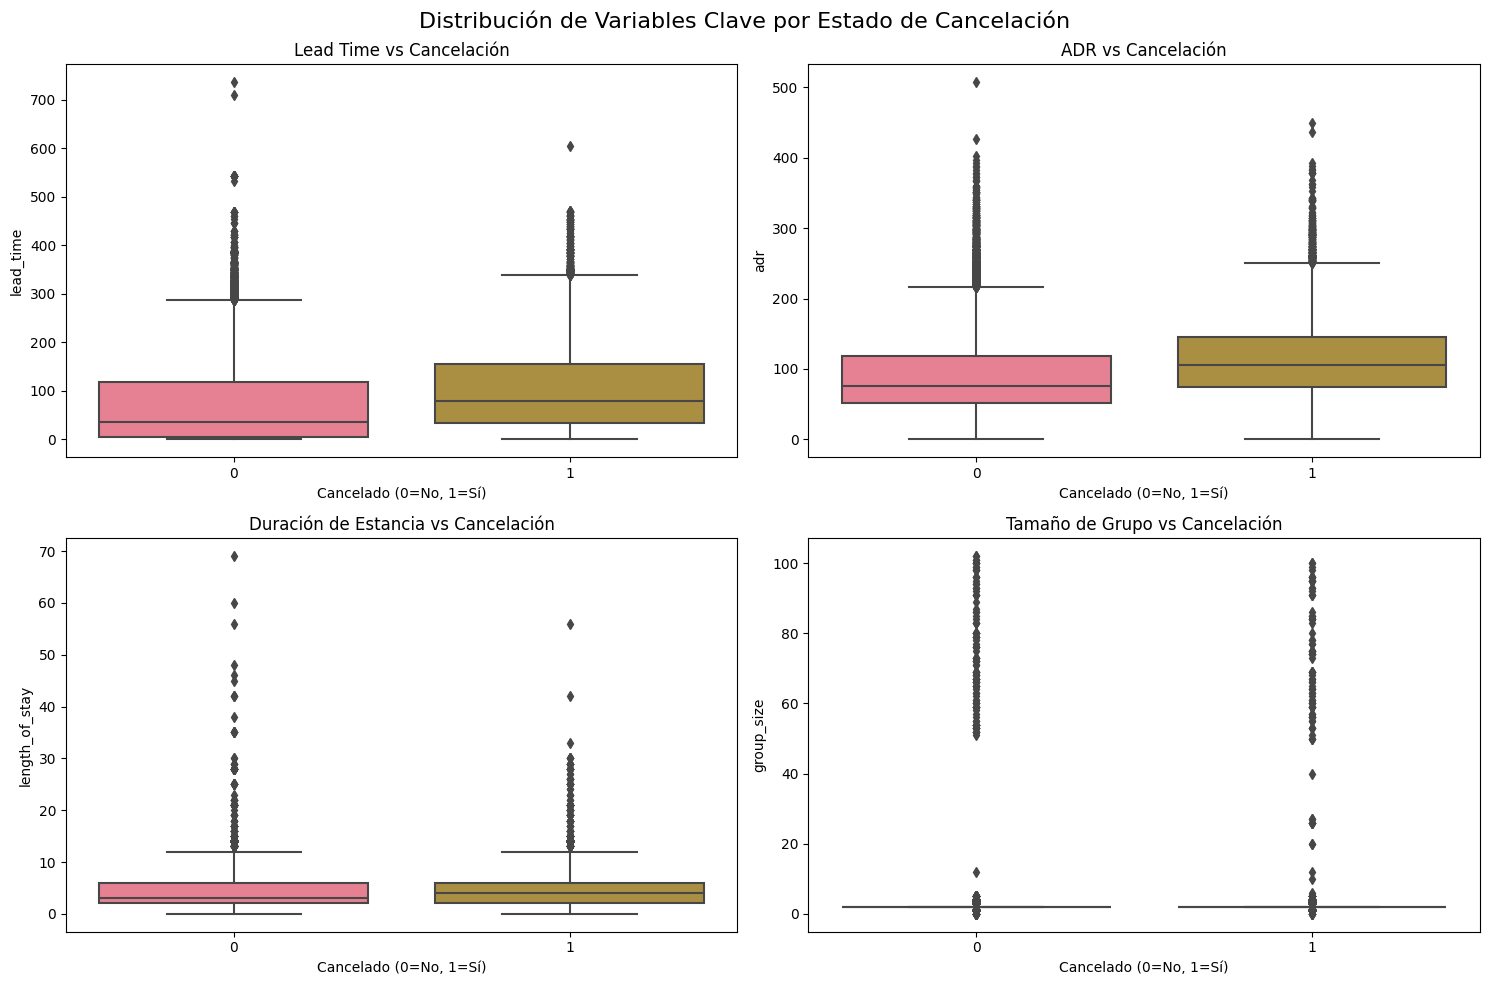


CANCELACIONES POR TIPO DE HOTEL
              Total_Reservas  Cancelaciones  Tasa_Cancelacion
hotel                                                        
City Hotel             10488           6758            0.6444
Resort Hotel           33643           8031            0.2387

CANCELACIONES POR MES
arrival_date_month
January      0.1904
February     0.2721
March        0.3188
April        0.3807
May          0.3623
June         0.4298
July         0.3970
August       0.3954
September    0.3625
October      0.3005
November     0.1593
December     0.2011
Name: is_canceled, dtype: float64


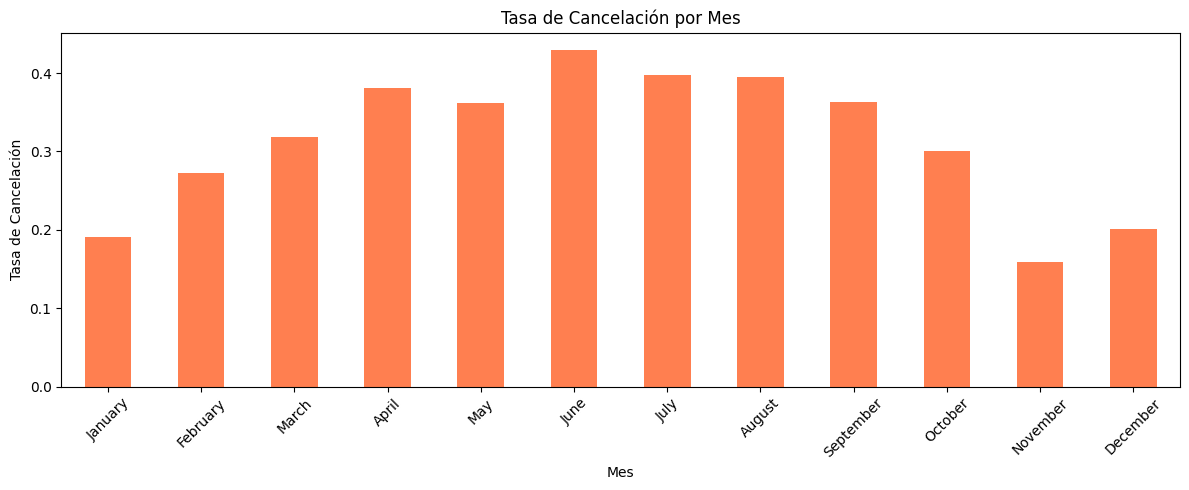


SEGMENTACIÓN DE CLIENTES MEDIANTE CLUSTERING
Datos para clustering: 38506 registros

ANÁLISIS PCA
Varianza explicada por componente:
PC1: 0.328 (0.328 acumulada)
PC2: 0.212 (0.540 acumulada)
PC3: 0.198 (0.738 acumulada)
PC4: 0.161 (0.898 acumulada)
PC5: 0.102 (1.000 acumulada)
Usando 3 componentes para clustering


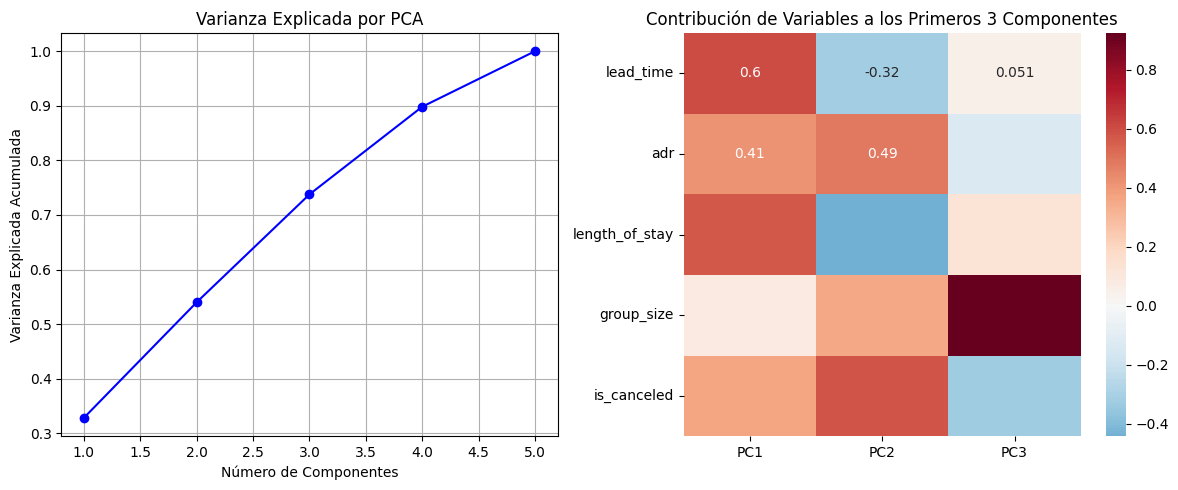


CLUSTERING K-MEANS
Usando 3 dimensiones para clustering
Error con K-means sklearn: 'NoneType' object has no attribute 'split'
Aplicando clustering alternativo...
Intentando DBSCAN...
DBSCAN encontró 3 clusters

CARACTERIZACIÓN DE 3 CLUSTERS
        lead_time           adr        length_of_stay       group_size         \
             mean    std   mean    std           mean   std       mean    std   
cluster                                                                         
-1          78.94  66.50  89.35  44.68           3.55  2.32      73.59  15.77   
 0          68.53  70.49  92.25  47.78           3.62  2.36       1.98   0.67   
 1          19.33  17.93  33.37   4.87           1.17  0.41      53.33   1.21   
 2           3.17   4.17  46.25  14.11           1.33  0.52      67.50   1.05   

        is_canceled         
               mean  count  
cluster                     
-1             0.39    155  
 0             0.33  38339  
 1             0.00      6  
 2             0

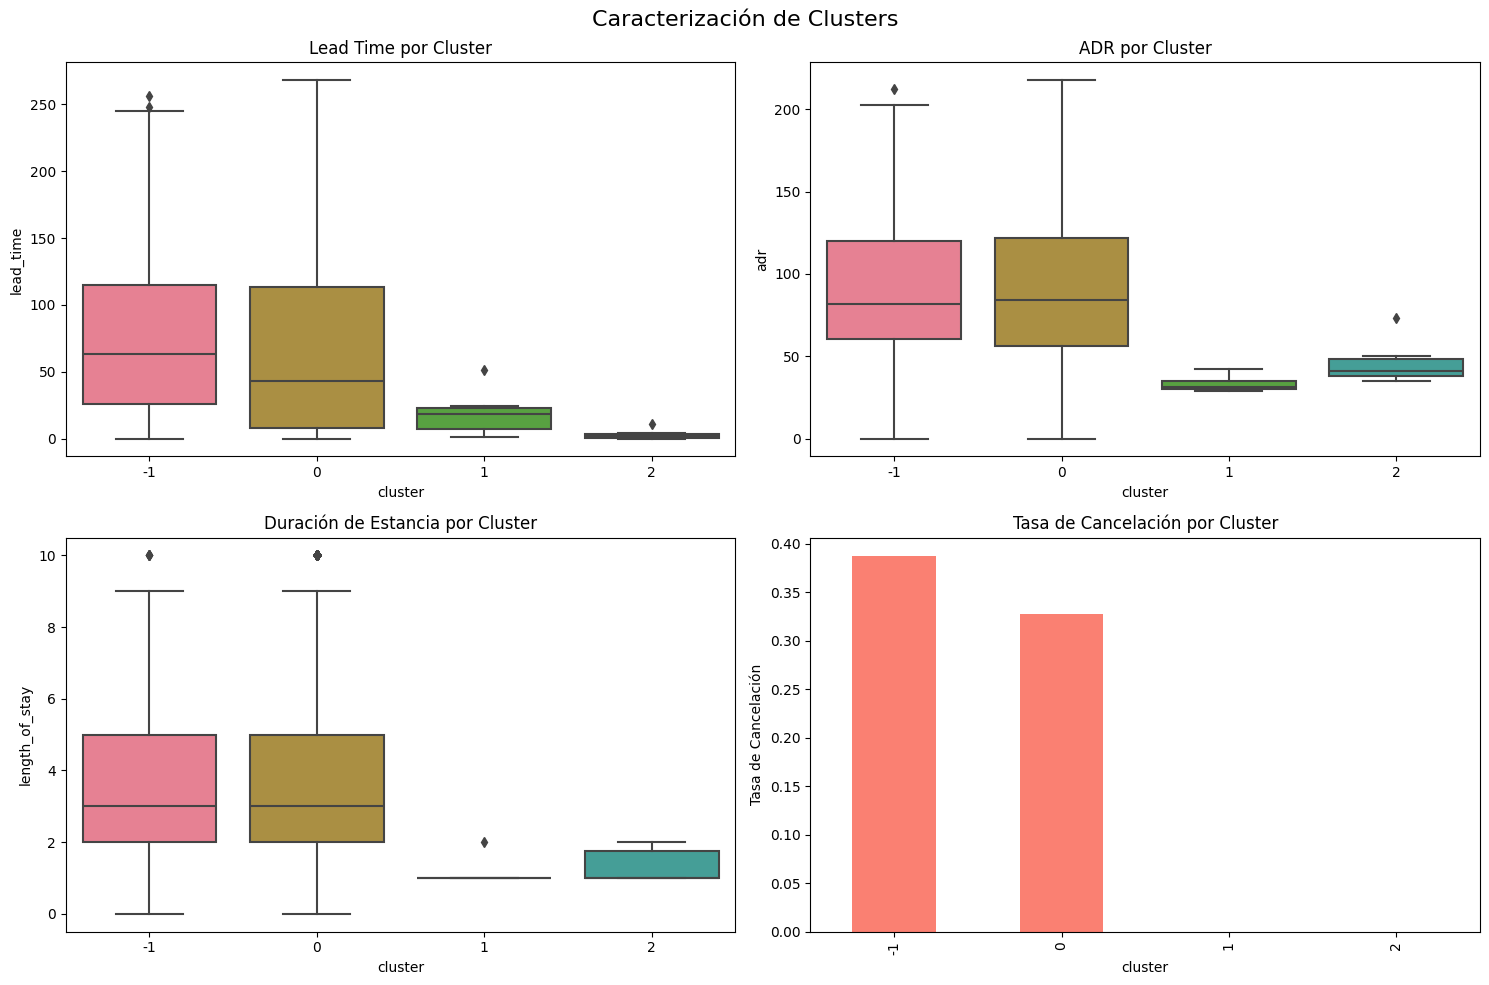


ANÁLISIS TEMPORAL Y ESTACIONALIDAD

ANÁLISIS DE ESTACIONALIDAD


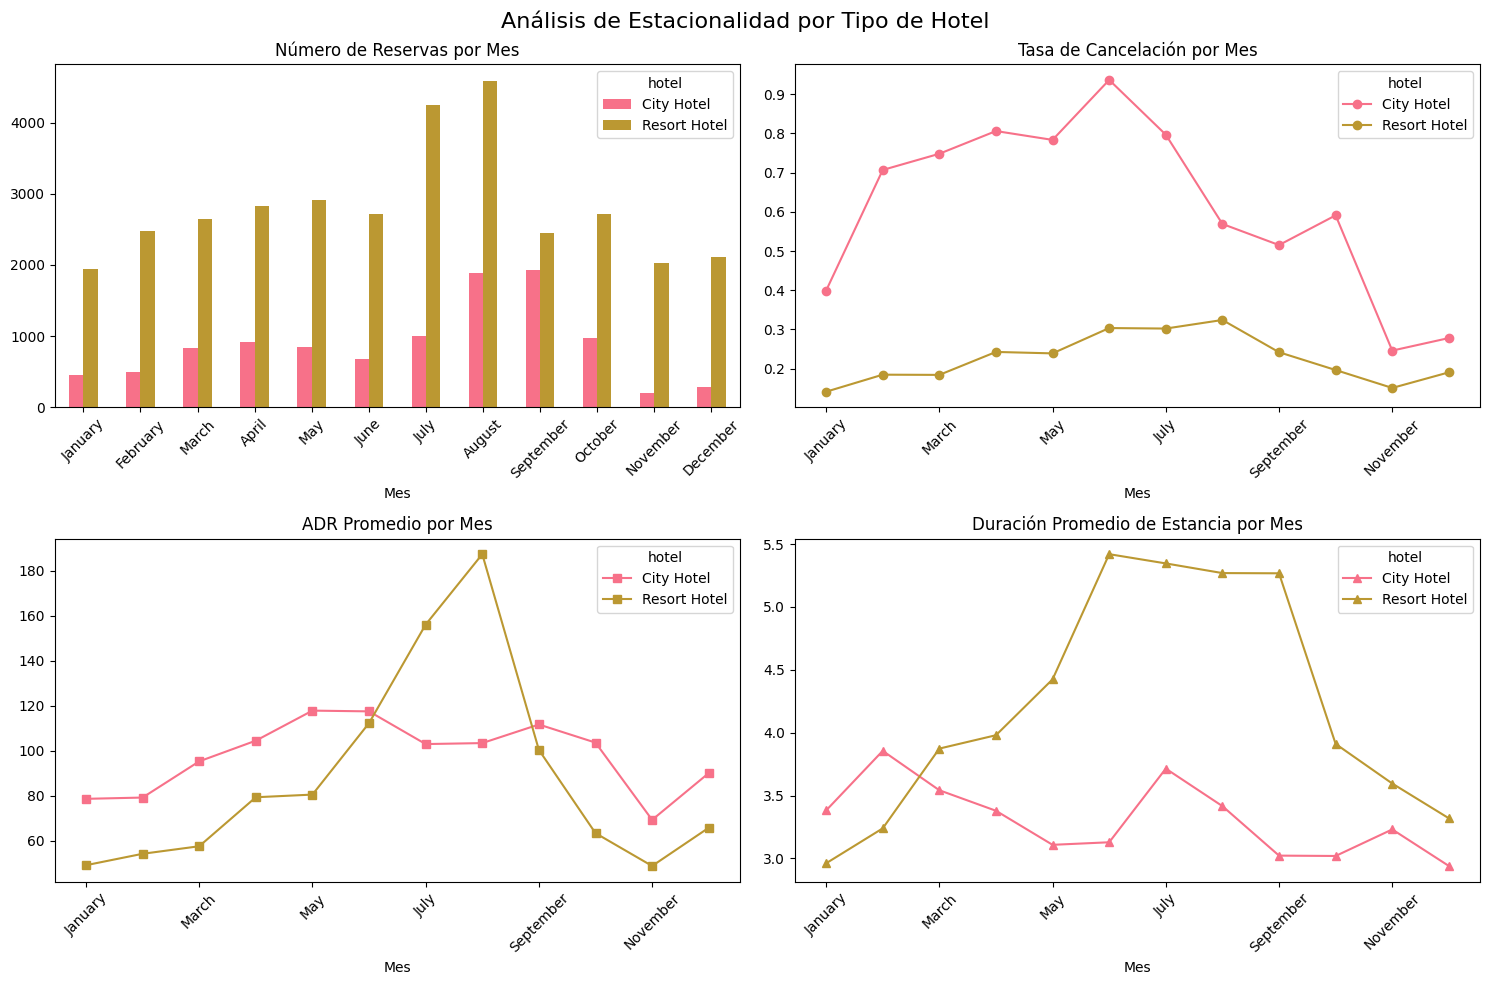


ANÁLISIS DE LEAD TIME
Análisis por segmento de Lead Time:
                                  is_canceled             adr
                                        count   mean     mean
lead_time_segment    hotel                                   
Último momento (0-7) City Hotel          1003  0.431   99.675
                     Resort Hotel        5244  0.069   78.935
Corto (8-30)         City Hotel          1925  0.655  113.232
                     Resort Hotel        5724  0.210  100.265
Medio (31-90)        City Hotel          3472  0.675  103.616
                     Resort Hotel        7503  0.301  109.251
Largo (91-365)       City Hotel          3576  0.706  100.568
                     Resort Hotel       11943  0.337  107.209
Muy largo (365+)     City Hotel           113  0.876   66.834
                     Resort Hotel         202  0.267   66.174


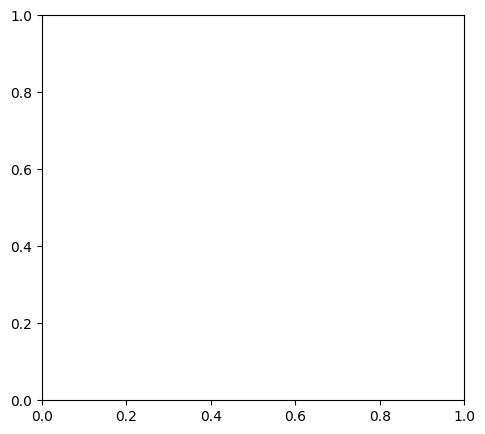

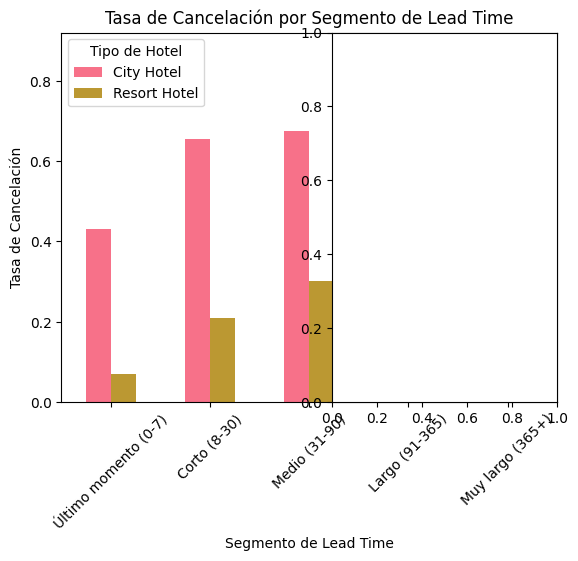

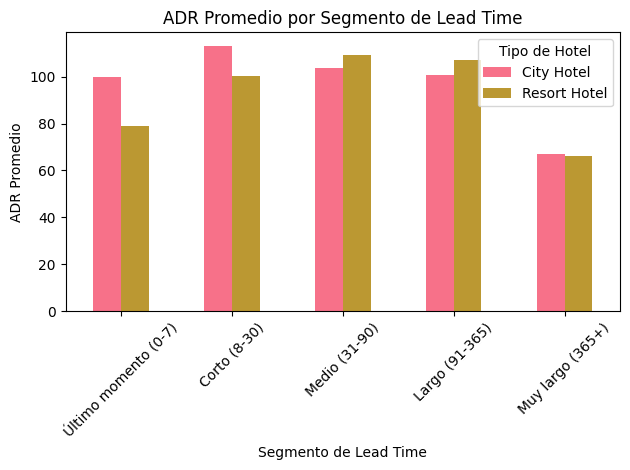


ANÁLISIS DE CANALES DE DISTRIBUCIÓN Y EMPRESAS

ANÁLISIS DE AGENCIAS DE VIAJE (TOP 15)
       Total_Reservas  Tasa_Cancelacion  ADR_Promedio  Revenue_Efectivo
agent                                                                  
240.0           12802              0.38        117.36     930793.422739
9.0              6142              0.74        114.25     180167.461486
250.0            2733              0.18        133.67     300366.060099
241.0            1606              0.13        101.95     141915.362092
40.0              943              0.08         84.26      73133.547105
314.0             834              0.15         78.12      55155.031007
1.0               747              0.47         64.65      25473.713976
6.0               737              0.18         63.43      38248.396364
242.0             712              0.33        123.60      59081.726461
8.0               502              0.35         83.62      27092.712191
243.0             467              0.06         

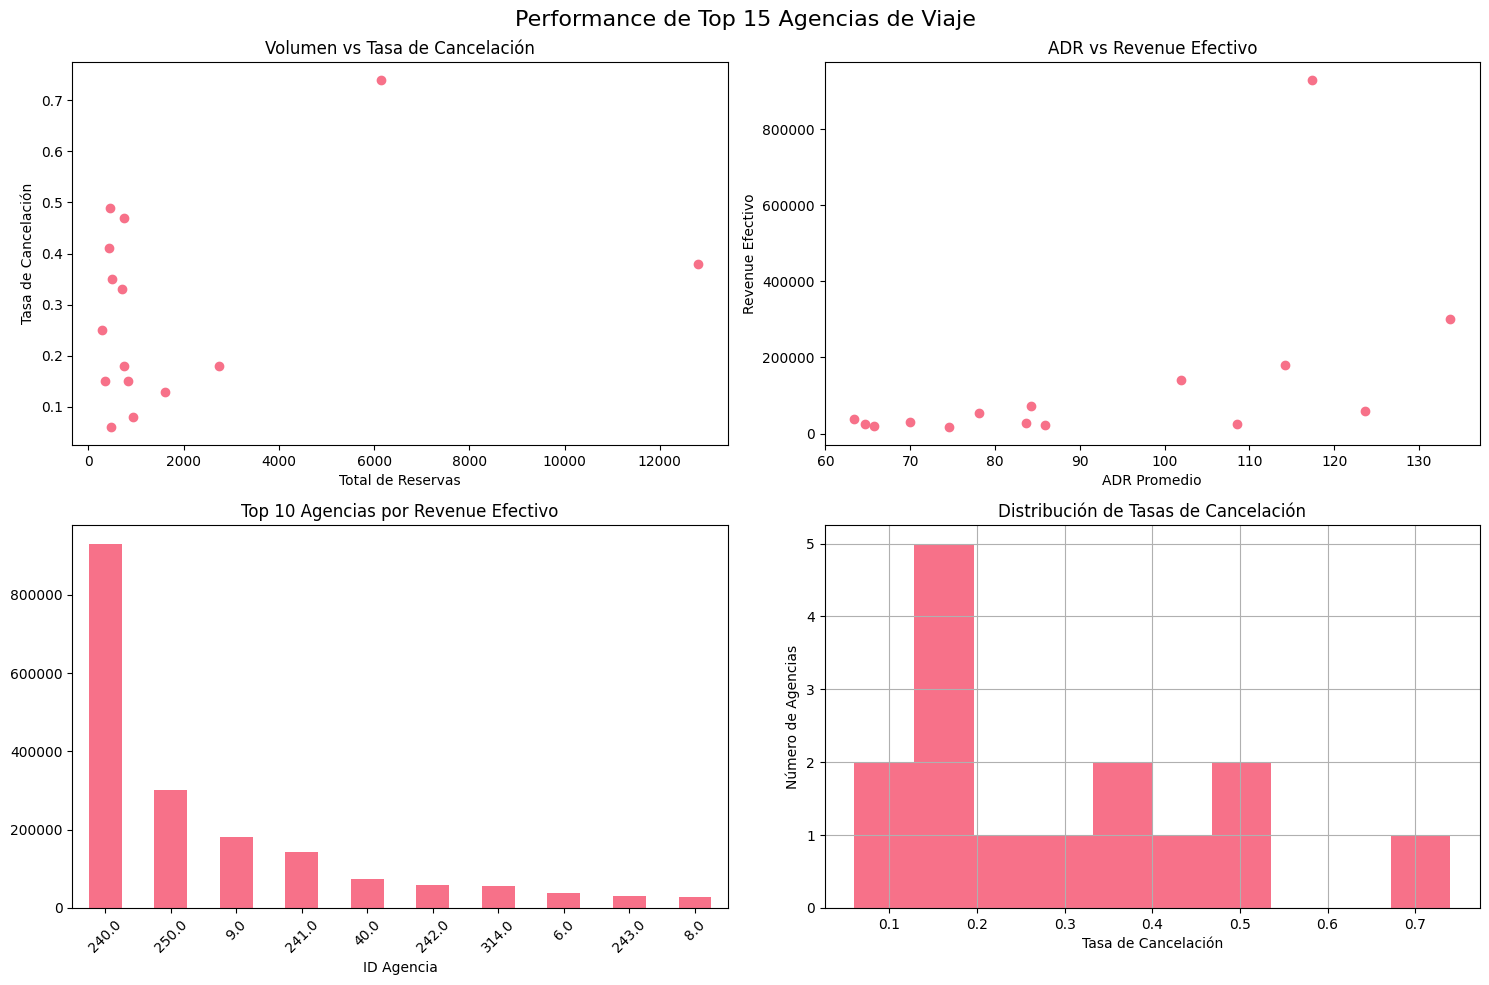


ANÁLISIS DE EMPRESAS CORPORATIVAS (TOP 15)
         Total_Reservas  Tasa_Cancelacion  ADR_Promedio  Revenue_Efectivo
company                                                                  
223                 510              0.05         56.50      27232.527451
154                 132              0.04         48.68       6181.773106
281                 118              0.14         42.70       4355.780339
94                   73              0.08         39.67       2657.972603
405                  73              0.11         53.57       3481.952055
47                   59              0.10         49.10       2602.120339
331                  54              0.20         59.44       2555.792593
135                  53              0.19         53.27       2290.764151
110                  47              0.34         90.55       2807.050000
270                  43              0.14         47.98       1775.139535
40                   40              0.30         71.28       1995.9

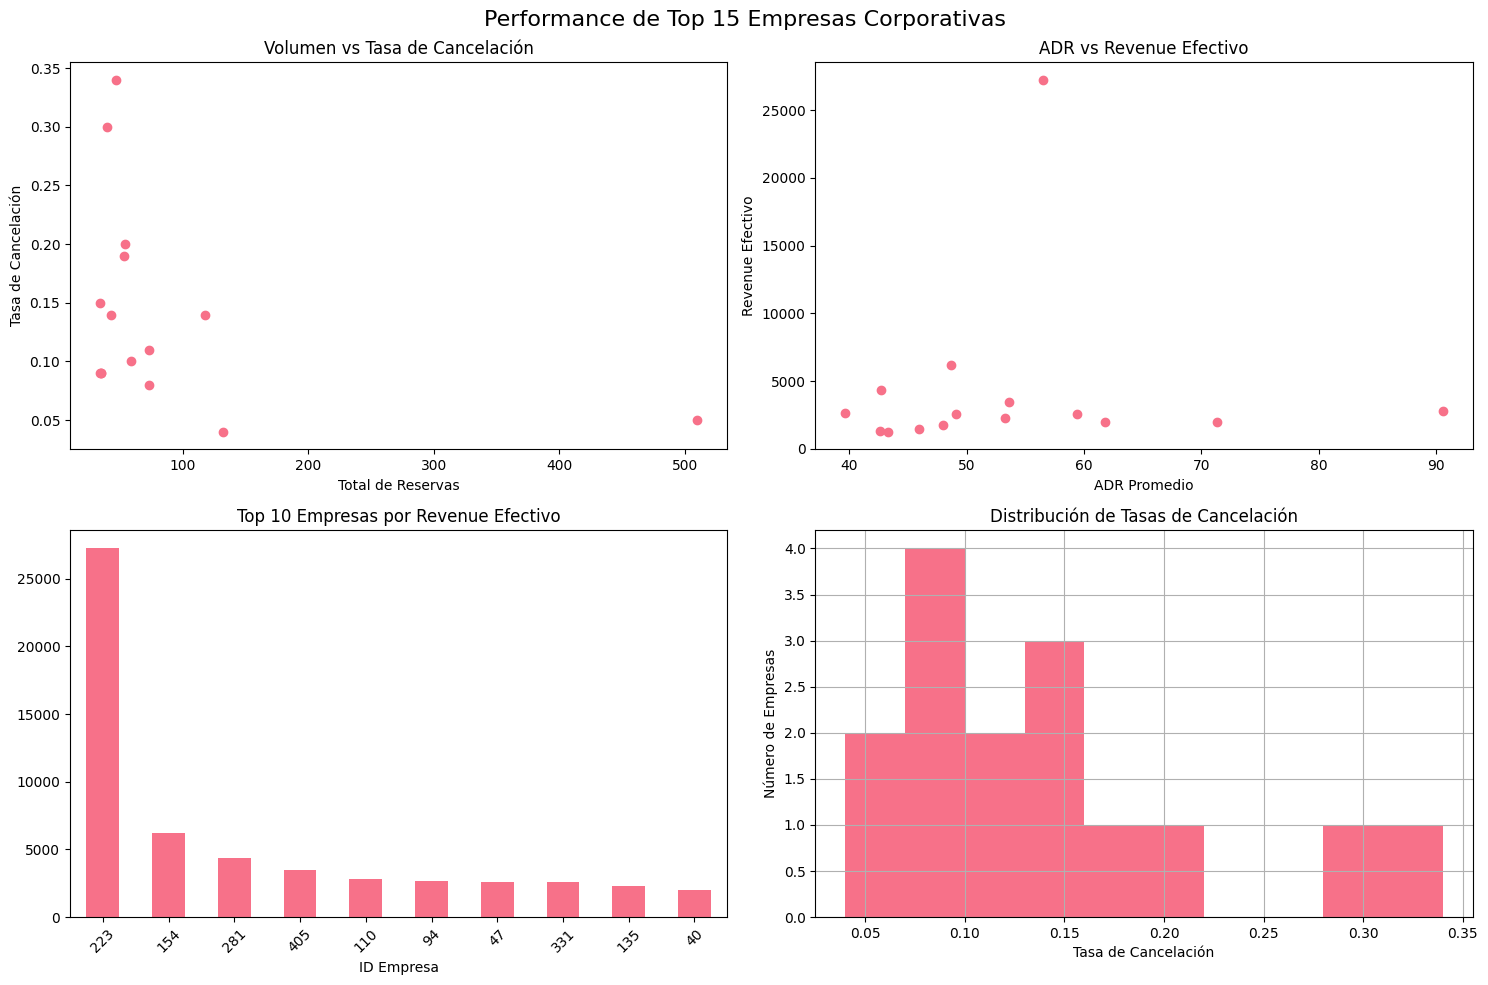


COMPARACIÓN DE CANALES DE DISTRIBUCIÓN
               Total_Reservas  Tasa_Cancelacion  ADR_Promedio  \
canal_reserva                                                   
Agencia                 36775             0.372       104.150   
Corporativo              2703             0.138        56.136   
Directo                  4653             0.155        90.906   

               Duracion_Promedio  
canal_reserva                     
Agencia                    4.395  
Corporativo                2.582  
Directo                    2.908  


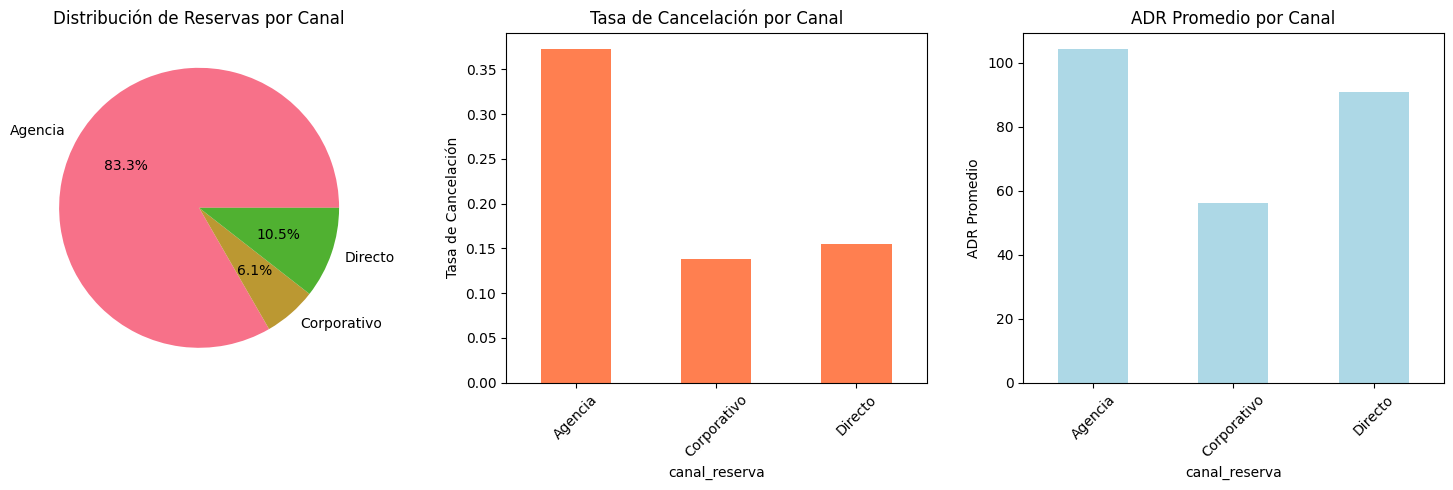


ESTRATEGIA COMPLETADA - RESULTADOS LISTOS PARA INFORME EJECUTIVO


In [251]:
# Ejemplo de uso - Estrategia completa:
resultados = ejecutar_estrategia_hotelera(hotels_df_clean)